In [1]:
import pandas as pd
import numpy as np
from gtfs_functions import Feed, gtfs_plots
import os
import folium
import networkx as nx
import matplotlib.pyplot as plt
from rich import print as rprint

## Loading data


In [2]:
feed = Feed("./STM GTFS/gtfs_stm.zip", busiest_date=False)

In [3]:
routes = feed.routes
trips = feed.trips
stops = feed.stops
stop_times = feed.stop_times
shapes = feed.shapes
segments = feed.segments

INFO:root:Reading "routes.txt".
INFO:root:accessing trips
INFO:root:Reading "trips.txt".
INFO:root:Reading "stop_times.txt".
INFO:root:_trips is defined in stop_times
INFO:root:Reading "stops.txt".
INFO:root:computing patterns
INFO:root:Reading "shapes.txt".
INFO:root:segments_df: 20458, geometry: 20458


## Compute distance matrix for all stops on a route


In [4]:
def get_segment_stops(segment_df, route_id, direction_id=0):
    segment_distance = segment_df.query(
        "route_id == @route_id & direction_id == @direction_id"
    )

    stops_in_route = stops[
        stops["stop_id"].isin(
            list(
                set(
                    segment_distance[["start_stop_id", "end_stop_id"]].values.reshape(
                        -1
                    )
                )
            )
        )
    ]

    return segment_distance, stops_in_route

In [5]:
def get_stop_name(stop_id, stops_route):
    return stops_route.query("stop_id == @stop_id").iloc[0]["stop_name"]

In [6]:
def get_distance(start, end, distances):
    start_index = distances[distances["start_stop_id"] == start].index[0]
    end_index = distances[distances["start_stop_id"] == end].index[0]

    starting_point = min(start_index, end_index)
    ending_point = max(start_index, end_index)

    return distances.iloc[starting_point:ending_point]["distance_m"].sum()


def build_distance_matrix(stops_route, segment_route):
    distances = segment_route[["start_stop_id", "end_stop_id", "distance_m"]]

    # Add end row
    distances.loc[distances.index.max() + 1] = [
        distances["end_stop_id"].iloc[-1],
        "END",
        0,
    ]

    # Add start row
    distances.loc[-1] = ["START", distances["start_stop_id"].iloc[0], 0]
    distances.index += 1

    distances = distances.sort_index().reset_index(drop=True)

    distance_matrix = np.zeros((len(stops_route), len(stops_route)))

    stops_to_index = {
        stop: index for index, stop in enumerate(stops_route["stop_id"].tolist())
    }
    index_to_stops = {index: stop for stop, index in stops_to_index.items()}

    index_to_stopname = {
        index: f"{stop} ({get_stop_name(stop, stops_route)})"
        for stop, index in stops_to_index.items()
    }

    for start_stop in stops_to_index.keys():
        for end_stop in stops_to_index.keys():
            distance_matrix[
                stops_to_index[start_stop], stops_to_index[end_stop]
            ] = get_distance(start_stop, end_stop, distances)

    return distance_matrix, stops_to_index, index_to_stops, index_to_stopname

In [7]:
def show_distance_matrix_for_route(segments, route_id, direction_id):
    segment_route, stops_route = get_segment_stops(segments, route_id, direction_id)

    (
        distance_matrix,
        stops_to_index,
        index_to_stops,
        index_to_stopname,
    ) = build_distance_matrix(stops_route, segment_route)

    # Plot distance matrix
    plt.figure(figsize=(20, 20))

    plt.imshow(distance_matrix / 1000)
    plt.xlabel("End Stop")
    plt.ylabel("Start Stop")
    cbar = plt.colorbar()
    cbar.set_label("Distance (km)", rotation=270, labelpad=20)

    stop_names = [index_to_stopname[i] for i in range(len(stops_route))]

    # change ticks to stop names
    plt.xticks(
        range(len(stops_route)),
        stop_names,
        rotation=90,
    )

    plt.yticks(
        range(len(stops_route)),
        stop_names,
    )

    ax = plt.gca()
    ax.xaxis.tick_top()

    # Add distances
    for i in range(len(stops_route)):
        for j in range(len(stops_route)):
            plt.text(
                j,
                i,
                round(distance_matrix[i, j] / 1000, 1),
                ha="center",
                va="center",
                color="w",
                fontsize=10,
                fontweight="bold",
            )

    plt.title(f"Distance Matrix for Route {route_id} (Direction: {direction_id})")
    plt.tight_layout()
    plt.show()

    return {
        "routes": (segment_route, stops_route),
        "distances": (distance_matrix, stops_to_index, index_to_stops, index_to_stopname),
    }

#### Plot distance matrix

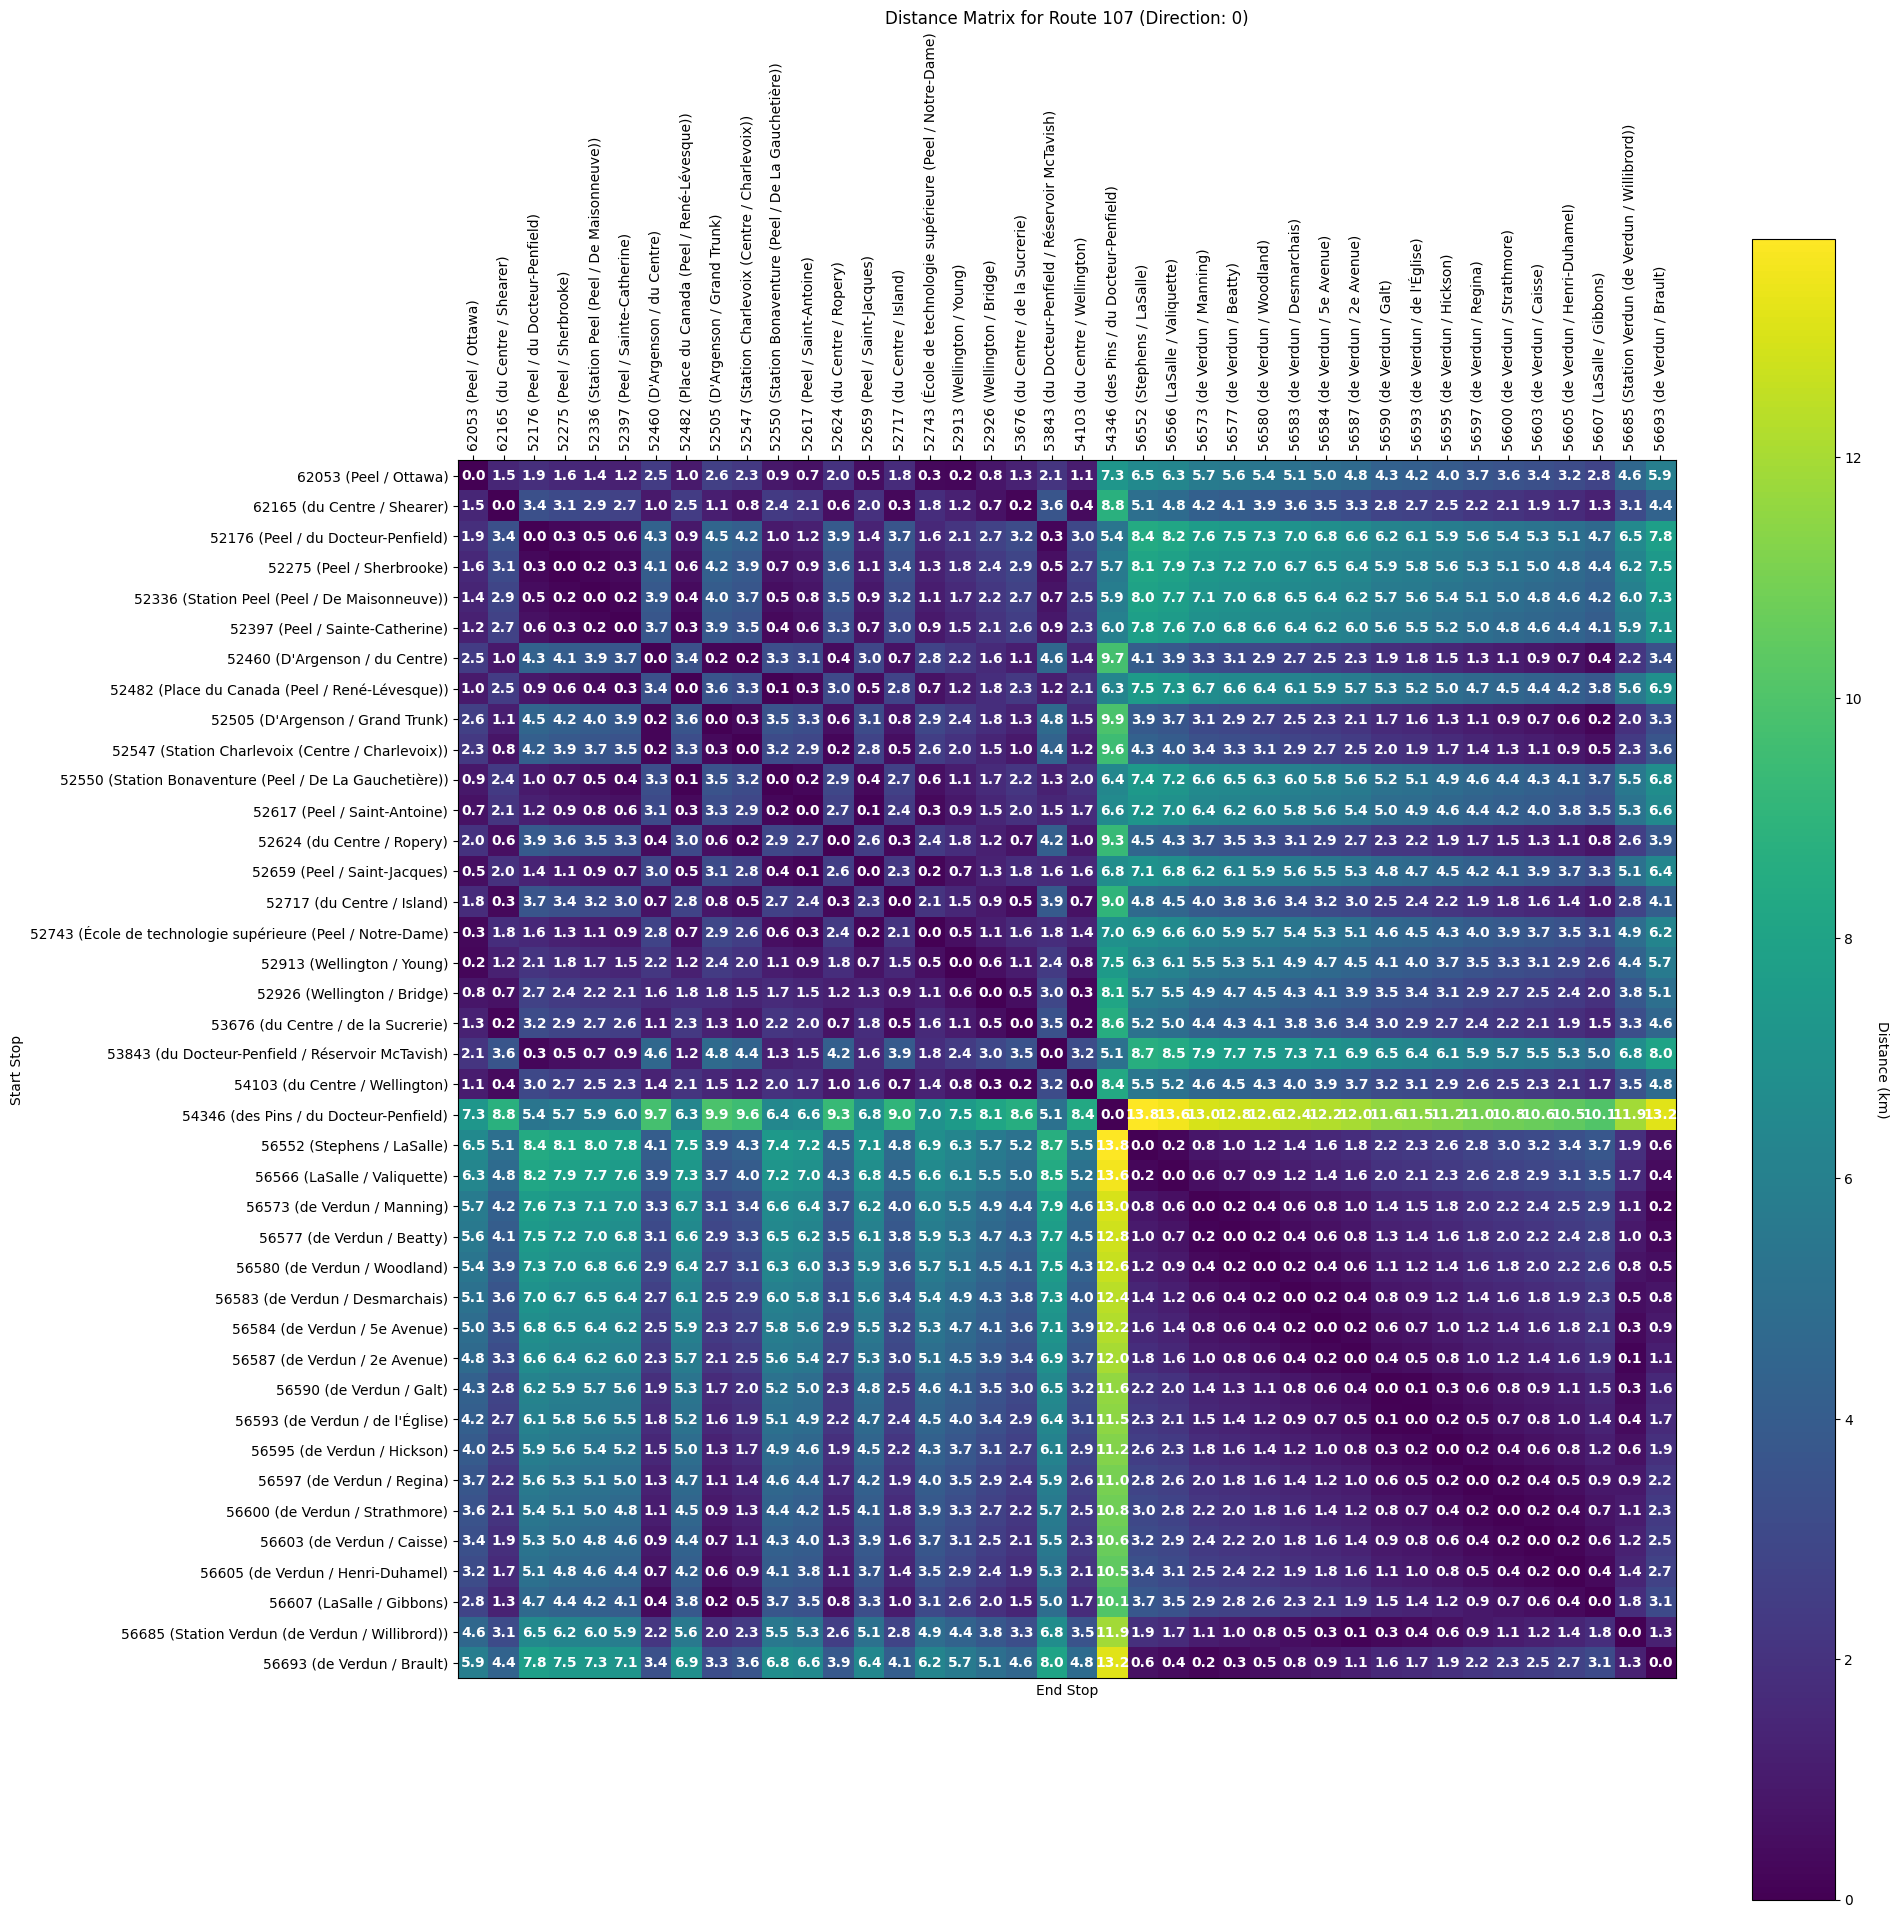

In [16]:
r = show_distance_matrix_for_route(segments, "107", 0)

#### Additional plots

In [20]:
segment_route, stops_route = r["routes"]

##### NetworkX graph

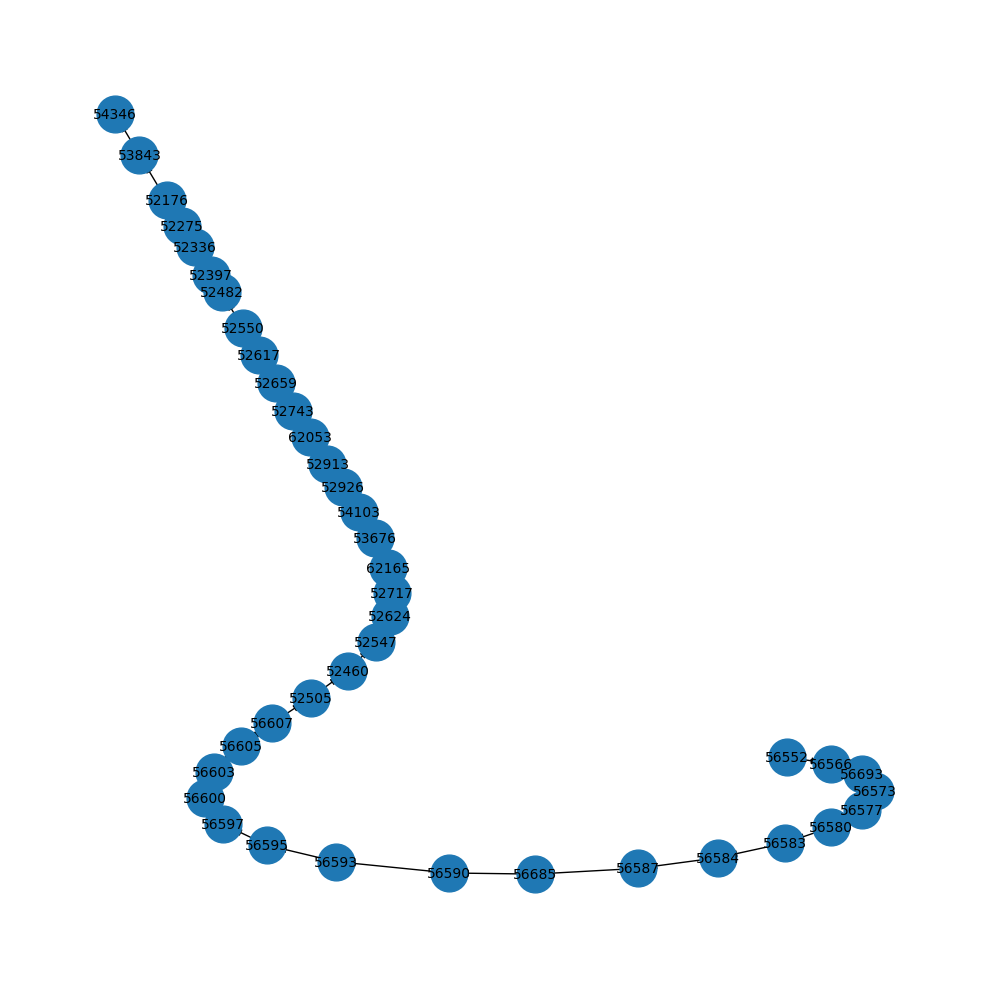

In [21]:
plt.figure(figsize=(10, 10))
G = nx.DiGraph()

for index, row in segment_route.iterrows():
    G.add_edge(
        row["start_stop_id"], row["end_stop_id"], weight=round(row["distance_m"], 1)
    )

pos = nx.spring_layout(G, seed=420)

nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, width=1)
nx.draw_networkx_labels(G, pos, font_size=10)


ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

##### Map

In [23]:
m = folium.Map(location=[45.508888, -73.561668], zoom_start=11, tiles="cartodbpositron")

folium.GeoJson(segment_route["geometry"]).add_to(m)

for index, row in stops_route.iterrows():
    location = (row["stop_lat"], row["stop_lon"])
    folium.CircleMarker(
        location,
        tooltip=f'{row["stop_name"]} ({row["stop_code"]})',
        radius=1.5,
        color="red",
    ).add_to(m)

m

## Compute distance matrix for all stops on a 2 route network




In [24]:
def find_common_stops(route1, route2):
    s_1 = get_segment_stops(segments, route1, 0)
    s_2 = get_segment_stops(segments, route2, 0)

    common_stops = set(s_1[1]["stop_code"].drop_duplicates().tolist()).intersection(
        set(s_2[1]["stop_code"].drop_duplicates().tolist())
    )

    print(f"{len(common_stops)} common stops between routes {route1} and {route2}")
    return (s_1, s_2, common_stops, True) if len(common_stops) > 0 else (None, False)

In [29]:
from itertools import combinations

random_generator = np.random.default_rng(seed=42)

route_combos = list(combinations(segments["route_id"].drop_duplicates().tolist(), 2))

common_stops_between_routes = {}

for r in random_generator.choice(route_combos, 100):
    print(f"Checking routes {r[0]} and {r[1]}")
    common_stops_between_routes[(r[0], r[1])] = find_common_stops(r[0], r[1])

Checking routes 109 and 115
0 common stops between routes 109 and 115
Checking routes 360 and 380
0 common stops between routes 360 and 380
Checking routes 218 and 444
0 common stops between routes 218 and 444
Checking routes 176 and 192
0 common stops between routes 176 and 192
Checking routes 175 and 219
0 common stops between routes 175 and 219
Checking routes 405 and 95
0 common stops between routes 405 and 95
Checking routes 108 and 425
0 common stops between routes 108 and 425
Checking routes 27 and 67
0 common stops between routes 27 and 67
Checking routes 124 and 22
0 common stops between routes 124 and 22
Checking routes 109 and 4
0 common stops between routes 109 and 4
Checking routes 192 and 406
0 common stops between routes 192 and 406
Checking routes 61 and 71
8 common stops between routes 61 and 71
Checking routes 350 and 56
0 common stops between routes 350 and 56
Checking routes 357 and 405
0 common stops between routes 357 and 405
Checking routes 31 and 75
0 common sto

In [30]:
for k, v in common_stops_between_routes.items():
    if v[-1]:
        print(f"Routes {k[0]} and {k[1]} have common stops: {v[-2]}")

Routes 61 and 71 have common stops: {52871, 53899, 53900, 56718, 56719, 52887, 60540, 52893}
Routes 356 and 485 have common stops: {57537}
Routes 364 and 430 have common stops: {53032, 60683, 52782, 61807, 53073, 52882, 52627, 52530, 52982, 53918}
Routes 22 and 410 have common stops: {53488, 53451, 53468}


In [32]:
c = common_stops_between_routes[('61', '71')]
c[-2]

{52871, 52887, 52893, 53899, 53900, 56718, 56719, 60540}

In [33]:
s_1, s_2 = c[0], c[1]

segment_1, stops_1 = s_1[0], s_1[1]
segment_2, stops_2 = s_2[0], s_2[1]

In [34]:
distances1 = segment_1[["start_stop_id", "end_stop_id", "distance_m"]]

# Add end row
distances1.loc[distances1.index.max() + 1] = [
    distances1["end_stop_id"].iloc[-1],
    "END",
    0,
]

# Add start row
distances1.loc[-1] = ["START", distances1["start_stop_id"].iloc[0], 0]
distances1.index += 1

distances1 = distances1.sort_index().reset_index(drop=True)

##### Manually calcuating the distance between two transit points separated by a transfer

In [35]:
distances2 = segment_2[["start_stop_id", "end_stop_id", "distance_m"]]

# Add end row
distances2.loc[distances2.index.max() + 1] = [
    distances2["end_stop_id"].iloc[-1],
    "END",
    0,
]

# Add start row
distances2.loc[-1] = ["START", distances2["start_stop_id"].iloc[0], 0]
distances2.index += 1

distances2 = distances2.sort_index().reset_index(drop=True)

In [36]:
get_distance("55302", "61756", distances2)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [37]:
get_distance("55302", "55317", distances1)

IndexError: index 0 is out of bounds for axis 0 with size 0

##### Generating a distance matrix for a 2 route network using Dijkstra's algorithm


In [38]:
graph_1 = nx.Graph()
graph_2 = nx.Graph()

for index, row in segment_1.iterrows():
    graph_1.add_edge(row["start_stop_id"], row["end_stop_id"], weight=row["distance_m"])

for index, row in segment_2.iterrows():
    graph_2.add_edge(row["start_stop_id"], row["end_stop_id"], weight=row["distance_m"])

In [39]:
graph_1.update(graph_2)

In [40]:
pairs_distance = dict(nx.all_pairs_dijkstra_path_length(graph_1))

In [41]:
# convert pairs distance to matrix
pd.DataFrame(pairs_distance)

,56706,56619,56621,56627,56629,56631,56636,56638,56715,56718,...,52911,52829,52796,52716,52623,54018,52473,61209,61210,61868
56706,0.000000,336.237855,569.320442,771.836108,944.021592,1157.076207,1255.256415,1493.674643,1775.250022,1944.764855,...,3858.614253,4128.635729,4283.407214,4534.789090,4807.337942,5239.997740,5447.615082,5787.344913,5940.019345,6268.129413
56619,336.237855,0.000000,233.082587,435.598253,607.783737,820.838352,919.018560,1157.436788,1439.012167,1608.527000,...,3522.376398,3792.397874,3947.169359,4198.551235,4471.100087,4903.759885,5111.377227,5451.107057,5603.781490,5931.891558
56621,569.320442,233.082587,0.000000,202.515667,374.701150,587.755765,685.935973,924.354201,1205.929580,1375.444413,...,3289.293811,3559.315287,3714.086772,3965.468648,4238.017500,4670.677298,4878.294640,5218.024471,5370.698903,5698.808971
56627,771.836108,435.598253,202.515667,0.000000,172.185483,385.240099,483.420306,721.838535,1003.413913,1172.928747,...,3086.778145,3356.799620,3511.571106,3762.952982,4035.501834,4468.161632,4675.778974,5015.508804,5168.183236,5496.293304
56629,944.021592,607.783737,374.701150,172.185483,0.000000,213.054615,311.234823,549.653051,831.228430,1000.743263,...,2914.592661,3184.614137,3339.385622,3590.767498,3863.316350,4295.976148,4503.593490,4843.323321,4995.997753,5324.107821
56631,1157.076207,820.838352,587.755765,385.240099,213.054615,0.000000,98.180207,336.598436,618.173815,787.688648,...,2701.538046,2971.559521,3126.331007,3377.712883,3650.261735,4082.921533,4290.538875,4630.268705,4782.943138,5111.053205
56636,1255.256415,919.018560,685.935973,483.420306,311.234823,98.180207,0.000000,238.418228,519.993607,689.508441,...,2603.357839,2873.379314,3028.150799,3279.532676,3552.081528,3984.741326,4192.358667,4532.088498,4684.762930,5012.872998
56638,1493.674643,1157.436788,924.354201,721.838535,549.653051,336.598436,238.418228,0.000000,281.575379,451.090212,...,2364.939610,2634.961086,2789.732571,3041.114447,3313.663299,3746.323097,3953.940439,4293.670270,4446.344702,4774.454770
56715,1775.250022,1439.012167,1205.929580,1003.413913,831.228430,618.173815,519.993607,281.575379,0.000000,169.514833,...,2083.364231,2353.385707,2508.157192,2759.539068,3032.087921,3464.747718,3672.365060,4012.094891,4164.769323,4492.879391
56718,1944.764855,1608.527000,1375.444413,1172.928747,1000.743263,787.688648,689.508441,451.090212,169.514833,0.000000,...,1913.849398,2183.870873,2338.642359,2590.024235,2862.573087,3295.232885,3502.850227,3842.580057,3995.254490,4323.364558


## Compute distance matrix for all stops on an N-route network


In [8]:
routes = ["35", "61", "15"]
route_details = {}

for r in routes:
    detail = get_segment_stops(segments, r, 0)

    graph = nx.Graph()

    route_details[r] = {}
    route_details[r]["segment"] = detail[0]
    route_details[r]["stops"] = detail[1]

    for index, row in detail[0].iterrows():
        graph.add_edge(
            row["start_stop_id"],
            row["end_stop_id"],
            weight=row["distance_m"] / 1000,
            label=r,
        )

    route_details[r]["graph"] = graph

In [9]:
stops_df = pd.concat([v["stops"] for k, v in route_details.items()]).drop_duplicates()
len(stops_df)

68

In [57]:
combined_graph = nx.Graph()
for k, v in route_details.items():
    combined_graph = nx.compose(combined_graph, route_details[k]["graph"])

In [58]:
len(combined_graph.edges)

66

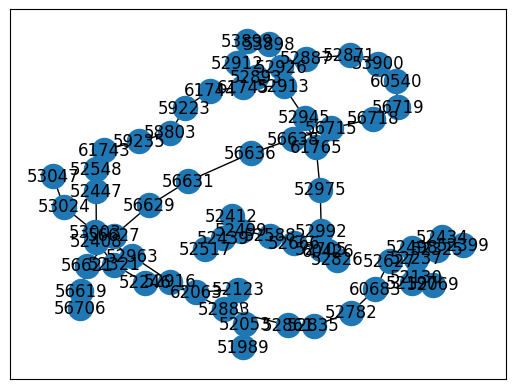

In [59]:
combined_graph = nx.compose_all([v["graph"] for k, v in route_details.items()])

nx.draw_networkx(combined_graph, with_labels=True)

In [60]:
distance_matrix = pd.DataFrame(dict(nx.all_pairs_dijkstra_path_length(combined_graph)))

In [61]:
pd.DataFrame(dict(nx.all_pairs_shortest_path(combined_graph)))

,51989,52053,52123,62063,52246,52321,52408,52447,52548,61743,...,60683,52782,52835,52861,52883,52916,52963,53003,53024,53047
51989,[51989],"[52053, 51989]","[52123, 52053, 51989]","[62063, 52123, 52053, 51989]","[52246, 62063, 52123, 52053, 51989]","[52321, 52246, 62063, 52123, 52053, 51989]","[52408, 52321, 52246, 62063, 52123, 52053, 51989]","[52447, 52408, 52321, 52246, 62063, 52123, 520...","[52548, 52447, 52408, 52321, 52246, 62063, 521...","[61743, 52548, 52447, 52408, 52321, 52246, 620...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52053,"[51989, 52053]",[52053],"[52123, 52053]","[62063, 52123, 52053]","[52246, 62063, 52123, 52053]","[52321, 52246, 62063, 52123, 52053]","[52408, 52321, 52246, 62063, 52123, 52053]","[52447, 52408, 52321, 52246, 62063, 52123, 52053]","[52548, 52447, 52408, 52321, 52246, 62063, 521...","[61743, 52548, 52447, 52408, 52321, 52246, 620...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52123,"[51989, 52053, 52123]","[52053, 52123]",[52123],"[62063, 52123]","[52246, 62063, 52123]","[52321, 52246, 62063, 52123]","[52408, 52321, 52246, 62063, 52123]","[52447, 52408, 52321, 52246, 62063, 52123]","[52548, 52447, 52408, 52321, 52246, 62063, 52123]","[61743, 52548, 52447, 52408, 52321, 52246, 620...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62063,"[51989, 52053, 52123, 62063]","[52053, 52123, 62063]","[52123, 62063]",[62063],"[52246, 62063]","[52321, 52246, 62063]","[52408, 52321, 52246, 62063]","[52447, 52408, 52321, 52246, 62063]","[52548, 52447, 52408, 52321, 52246, 62063]","[61743, 52548, 52447, 52408, 52321, 52246, 62063]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52246,"[51989, 52053, 52123, 62063, 52246]","[52053, 52123, 62063, 52246]","[52123, 62063, 52246]","[62063, 52246]",[52246],"[52321, 52246]","[52408, 52321, 52246]","[52447, 52408, 52321, 52246]","[52548, 52447, 52408, 52321, 52246]","[61743, 52548, 52447, 52408, 52321, 52246]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[60683, 52782, 52835, 52861, 52883, 52916]","[52782, 52835, 52861, 52883, 52916]","[52835, 52861, 52883, 52916]","[52861, 52883, 52916]","[52883, 52916]",[52916],"[52963, 52916]","[53003, 52963, 52916]","[53024, 53003, 52963, 52916]","[53047, 53024, 53003, 52963, 52916]"
52963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[60683, 52782, 52835, 52861, 52883, 52916, 52963]","[52782, 52835, 52861, 52883, 52916, 52963]","[52835, 52861, 52883, 52916, 52963]","[52861, 52883, 52916, 52963]","[52883, 52916, 52963]","[52916, 52963]",[52963],"[53003, 52963]","[53024, 53003, 52963]","[53047, 53024, 53003, 52963]"
53003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[60683, 52782, 52835, 52861, 52883, 52916, 529...","[52782, 52835, 52861, 52883, 52916, 52963, 53003]","[52835, 52861, 52883, 52916, 52963, 53003]","[52861, 52883, 52916, 52963, 53003]","[52883, 52916, 52963, 53003]","[52916, 52963, 53003]","[52963, 53003]",[53003],"[53024, 53003]","[53047, 53024, 53003]"
53024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"[60683, 52782, 52835, 52861, 52883, 52916, 529...","[52782, 52835, 52861, 52883, 52916, 52963, 530...","[52835, 52861, 52883, 52916, 52963, 53003, 53024]","[52861, 52883, 52916, 52963, 53003, 53024]","[52883, 52916, 52963, 53003, 53024]","[52916, 52963, 53003, 53024]","[52963, 53003, 53024]","[53003, 53024]",[53024],"[53047, 53024]"


In [62]:
distance_matrix

,51989,52053,52123,62063,52246,52321,52408,52447,52548,61743,...,60683,52782,52835,52861,52883,52916,52963,53003,53024,53047
51989,0.000000,0.263512,0.427379,0.672261,0.815025,1.072613,1.388016,1.477391,1.854303,2.156428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52053,0.263512,0.000000,0.163867,0.408749,0.551513,0.809101,1.124504,1.213879,1.590791,1.892915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52123,0.427379,0.163867,0.000000,0.244882,0.387646,0.645234,0.960637,1.050012,1.426924,1.729048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62063,0.672261,0.408749,0.244882,0.000000,0.142764,0.400352,0.715755,0.805130,1.182042,1.484166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52246,0.815025,0.551513,0.387646,0.142764,0.000000,0.257588,0.572991,0.662366,1.039278,1.341402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.513458,1.209375,0.967295,0.264249,0.142241,0.000000,0.241838,0.492598,0.678016,0.821399
52963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.755296,1.451213,1.209133,0.506087,0.384079,0.241838,0.000000,0.250760,0.436178,0.579560
53003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.006056,1.701973,1.459894,0.756848,0.634839,0.492598,0.250760,0.000000,0.185417,0.328800
53024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.191474,1.887391,1.645311,0.942265,0.820256,0.678016,0.436178,0.185417,0.000000,0.143383


#### Save distance matrix

For segments with no path, the distance is set to a large number. This is not ideal, but it is the best we can do for now.


In [63]:
distance_matrix.to_json("distance_matrix.json")

In [54]:
from pyvis.network import Network

net = Network(notebook=True, cdn_resources="remote", select_menu=True, filter_menu=True)

net.from_nx(combined_graph)

net.show_buttons()

net.show("combined_graph.html")

combined_graph.html


## Manhattan distance

In [13]:
# Calculate Manhattan distance between all stops

from sklearn.metrics.pairwise import manhattan_distances

manhattan_distance_matrix = manhattan_distances(
    stops_df[["stop_lat", "stop_lon"]].values,
)

manhattan_distance_matrix

array([[0.      , 0.008143, 0.010303, ..., 0.047327, 0.048662, 0.020068],
       [0.008143, 0.      , 0.002676, ..., 0.039184, 0.040519, 0.016753],
       [0.010303, 0.002676, 0.      , ..., 0.037024, 0.038359, 0.019429],
       ...,
       [0.047327, 0.039184, 0.037024, ..., 0.      , 0.001335, 0.027259],
       [0.048662, 0.040519, 0.038359, ..., 0.001335, 0.      , 0.028594],
       [0.020068, 0.016753, 0.019429, ..., 0.027259, 0.028594, 0.      ]])

In [14]:
manhattan_distance_matrix

array([[0.      , 0.008143, 0.010303, ..., 0.047327, 0.048662, 0.020068],
       [0.008143, 0.      , 0.002676, ..., 0.039184, 0.040519, 0.016753],
       [0.010303, 0.002676, 0.      , ..., 0.037024, 0.038359, 0.019429],
       ...,
       [0.047327, 0.039184, 0.037024, ..., 0.      , 0.001335, 0.027259],
       [0.048662, 0.040519, 0.038359, ..., 0.001335, 0.      , 0.028594],
       [0.020068, 0.016753, 0.019429, ..., 0.027259, 0.028594, 0.      ]])

In [25]:
stops_df

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,location_type,parent_station,wheelchair_boarding,geometry
422,61743,61743,Notre-Dame / Guy,45.489959,-73.567233,https://www.stm.info/fr/recherche#stq=61743,0,NaN,1,POINT (-73.56723 45.48996)
423,61744,61744,de la Montagne / Ottawa,45.492014,-73.561145,https://www.stm.info/fr/recherche#stq=61744,0,NaN,1,POINT (-73.56114 45.49201)
424,61745,61745,de la Montagne / du Square-Gallery,45.491756,-73.558727,https://www.stm.info/fr/recherche#stq=61745,0,NaN,1,POINT (-73.55873 45.49176)
438,61765,61765,Wellington / Prince,45.496656,-73.555554,https://www.stm.info/fr/recherche#stq=61765,0,NaN,1,POINT (-73.55555 45.49666)
591,62063,62063,Notre-Dame / Bérard,45.480191,-73.579727,https://www.stm.info/fr/recherche#stq=62063,0,NaN,1,POINT (-73.57973 45.48019)
...,...,...,...,...,...,...,...,...,...,...
3316,52963,52963,Station Beaudry (Ste-Catherine / de la Visitat...,45.519156,-73.555444,https://www.stm.info/fr/recherche#stq=52963,0,NaN,1,POINT (-73.55544 45.51916)
3349,53003,53003,Sainte-Catherine / Alexandre-DeSève,45.521058,-73.553695,https://www.stm.info/fr/recherche#stq=53003,0,NaN,1,POINT (-73.55370 45.52106)
3366,53024,53024,Sainte-Catherine / Papineau,45.522455,-73.552402,https://www.stm.info/fr/recherche#stq=53024,0,NaN,1,POINT (-73.55240 45.52246)
3387,53047,53047,Station Papineau (Cartier / Sainte-Catherine),45.523512,-73.552124,https://www.stm.info/fr/recherche#stq=53047,0,NaN,1,POINT (-73.55212 45.52351)
